In [71]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq
from tqdm import trange



## Compute exact solution for Allen-Cahn equation

In [72]:


class AllenCahnSpectral1D:
    def __init__(self, Nx, D=1e-4):
        """
        Initialize the Fourier spectral solver for the 1D Allen-Cahn equation
        u_t = D * u_xx + 5(u - u^3)
        """
        self.Nx = Nx
        self.D = D
        self.L = 2.0  # Domain length from -1 to 1
        
        # Set up the full grid (including endpoint)
        self.x_full = np.linspace(-1, 1, Nx)
        # Grid for computations (excluding endpoint)
        self.x = self.x_full[:-1]
        self.dx = self.L / (Nx - 1)
        
        # Compute wave numbers for Nx-1 points
        self.kx = 2 * np.pi * fftfreq(Nx-1)
        self.K2 = self.kx**2
        
    def set_initial_condition(self):
        """Set initial condition u(x,0) = x^2 * cos(πx)"""
        return self.x**2 * np.cos(np.pi * self.x)
    
    def step_RK4(self, u, dt):
        """Take one RK4 time step"""
        k1 = dt * self.rhs(u)
        k2 = dt * self.rhs(u + 0.5 * k1)
        k3 = dt * self.rhs(u + 0.5 * k2)
        k4 = dt * self.rhs(u + k3)
        return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    def rhs(self, u):
        """Compute RHS of the PDE in Fourier space"""
        u_hat = fft(u)
        
        # Diffusion term in Fourier space
        d_hat = -self.D * self.K2 * u_hat
        
        # Nonlinear term computed in physical space
        n = 5.0 * (u - u**3)
        n_hat = fft(n)
        
        # Combine terms and transform back
        return ifft(d_hat + n_hat).real
    
    def solve(self, T_final, dt=1e-3):
        """
        Solve the Allen-Cahn equation up to time T_final
        using RK4 time integration.
        """
        # Initialize solution (on periodic grid)
        u = self.set_initial_condition()
        t = 0
        
        # Calculate number of steps
        n_steps = int(np.ceil(T_final / dt))
            
        # Initialize storage for solutions (including endpoint) and time points
        u_record = np.zeros((n_steps + 1, self.Nx))
        t_record = np.zeros(n_steps + 1)
        
        # Store initial condition (including endpoint)
        u_record[0] = np.append(u, u[0])
        t_record[0] = t
        
        # Time stepping with progress bar
        pbar = trange(n_steps)
        for step in pbar:
            if t + dt > T_final:
                dt = T_final - t
            
            # RK4 time step (on periodic grid)
            u = self.step_RK4(u, dt)
            t += dt
            
            # Store solution (with periodic endpoint)
            u_record[step + 1] = np.append(u, u[0])
            t_record[step + 1] = t
            
            pbar.set_postfix({'t': f'{t:.3f}'})
        
        return u_record, t_record
    
    def get_grid(self):
        """Return the full computational grid (including endpoint)"""
        return self.x_full

In [73]:
Nx = 320           # Number of spatial grid points
D = 1e-4           # Diffusion coefficient
T_final = 1.0      # Final time
dt = 1e-3          # Time step size

solver = AllenCahnSpectral1D(Nx=Nx, D=D)
u_record, t_record = solver.solve(T_final, dt=dt)
x_full = solver.get_grid()


100%|██████████| 1000/1000 [00:01<00:00, 898.41it/s, t=1.000]


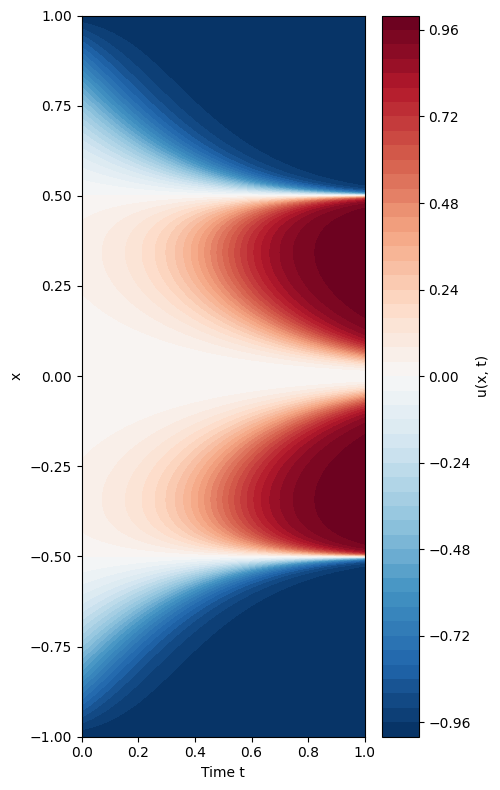

In [80]:

T_new, X_new = np.meshgrid(t_record, x_full, indexing='ij')

# Prepare the data for contour plotting
U = u_record  # Shape: (n_records, Nx)

# Plot contour of u(x, t) with t on x-axis and x on y-axis
plt.figure(figsize=(5, 8))
contour = plt.contourf(T_new, X_new, U, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(contour, label='u(x, t)')
plt.xlabel('Time t')     # t on x-axis
plt.ylabel('x')          # x on y-axis
plt.xlim(0, 1.)
plt.ylim(-1,1)
plt.tight_layout()
plt.show()


In [78]:
output_data = {
    'u': u_record,        # Shape: (n_timesteps, nx)
    't': t_record,        # Shape: (n_timesteps,)
    'x': x_full,         # Shape: (nx,)
    'D': solver.D        # Diffusion coefficient
}
np.save('./data/allen_cahn_ref.npy', output_data)